<a href="https://colab.research.google.com/github/rcpaffenroth/dac_raghu/blob/main/Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load data

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
%matplotlib inline

import json

from iterativenn.nn_modules.MaskedLinear import MaskedLinear

In [2]:
#name = 'circle'
name = 'MNIST'
#name = 'EMlocalization'
#name = 'LunarLander'

# Read the json info file
with open(f'4-data/info.json') as f:
    info = json.load(f)
# Read the start data
x_start = pd.read_parquet(f'4-data/{name}_start.parquet')
# Read the target data
x_target = pd.read_parquet(f'4-data/{name}_target.parquet')


# Dynamical system

In [3]:
x_size = x_start.shape[1]
padding_size = 100
z_size = x_size+padding_size
test_size = 500

This is the multiplicative fish that we derive in notebooks/develop/01-rcp-simple-fish.ipynb

It is:

$$
(W_1 \cdot x + b_1) \odot (W_2 \cdot x + b_2)
$$

In [4]:
class MultiplicativeFish(nn.Module):
    def __init__(self, W1, b1, W2, b2):
        super().__init__()
        self.W1 = W1
        self.b1 = torch.nn.Parameter(b1)    
        self.W2 = W2
        self.b2 = torch.nn.Parameter(b2)

    def forward(self, x):
        return (self.W1(x) + self.b1) * (self.W2(x) + self.b2)

    @staticmethod
    def get_identity(z_size):
        # Create a MultiplicativeFish that is the identity function
        W1 = MaskedLinear.from_description([z_size], [z_size], block_types=[['D']], initialization_types=[[1]], trainable=[[True]], bias=False)
        b1 = torch.zeros(z_size, requires_grad=True)
        W2 = MaskedLinear.from_description([z_size], [z_size], block_types=[['D']], initialization_types=[[0]], trainable=[[True]], bias=False) 
        b2 = torch.ones(z_size, requires_grad=True)
        return MultiplicativeFish(W1, b1, W2, b2) 

    @staticmethod
    def get_random(z_size):
        # Create a MultiplicativeFish that is the identity function
        W1 = MaskedLinear.from_description([z_size], [z_size], block_types=[['W']], initialization_types=[['G=0.0,0.01']], trainable=[[True]], bias=False)
        b1 = torch.zeros(z_size, requires_grad=True)
        W2 = MaskedLinear.from_description([z_size], [z_size], block_types=[['W']], initialization_types=[['G=0.0,0.01']], trainable=[[True]], bias=False) 
        b2 = torch.ones(z_size, requires_grad=True)
        return MultiplicativeFish(W1, b1, W2, b2) 


This is the discontinuous fish that we derive in notebooks/develop/01-rcp-simple-fish.ipynb

It is:

$$
f(x) = 
\begin{cases}
    W_1 \cdot x + b_1 & \text{if } x_j < 0 \\
    W_2 \cdot x + b_2 & \text{else}
\end{cases}
$$

In [5]:
class DiscontinuousFish(nn.Module):
    def __init__(self, W1, b1, W2, b2):
        super().__init__()
        self.W1 = W1
        self.b1 = torch.nn.Parameter(b1)    
        self.W2 = W2
        self.b2 = torch.nn.Parameter(b2)

    def forward(self, x):
        return torch.where(x < 0, self.W1(x) + self.b1, self.W2(x) + self.b2)
    
    @staticmethod
    def get_identity(z_size):
        # Create a DiscontinuousFish that is the identity function
        W1 = MaskedLinear.from_description([z_size], [z_size], block_types=[['D']], initialization_types=[[1]], trainable=[[True]], bias=False)
        b1 = torch.zeros(z_size, requires_grad=True)
        W2 = MaskedLinear.from_description([z_size], [z_size], block_types=[['D']], initialization_types=[[1]], trainable=[[True]], bias=False) 
        b2 = torch.zeros(z_size, requires_grad=True)
        return DiscontinuousFish(W1, b1, W2, b2)   
    
    @staticmethod
    def get_random(z_size):
        # Create a MultiplicativeFish that is the identity function
        W1 = MaskedLinear.from_description([z_size], [z_size], block_types=[['W']], initialization_types=[['G=0.0,0.01']], trainable=[[True]], bias=False)
        b1 = torch.zeros(z_size, requires_grad=True)
        W2 = MaskedLinear.from_description([z_size], [z_size], block_types=[['W']], initialization_types=[['G=0.0,0.01']], trainable=[[True]], bias=False) 
        b2 = torch.ones(z_size, requires_grad=True)
        return MultiplicativeFish(W1, b1, W2, b2) 

Do some unit tests to make sure the two fish do the right things.  This is a good idea

![Alt text](image.png)

I put this here to encourage people to do similiar things in their own code.

In [6]:
def test():
    X = torch.rand(1000, z_size)

    # These should be the identity map, this confirms that the implementation is correct
    with torch.no_grad():
        map = MultiplicativeFish.get_identity(z_size)
        Y = map(X)  
        assert torch.isclose(X, Y).all(), "MultiplicativeFish is not the identity map"

    with torch.no_grad():
        map = DiscontinuousFish.get_identity(z_size)
        Y = map(X)  
        assert torch.isclose(X, Y).all(), "DiscontinuousFish is not the identity map"

    # A slighlyt harder test.  The composition of two identity maps should be the identity map
    with torch.no_grad():
        map1 = MultiplicativeFish.get_identity(z_size)
        map2 = DiscontinuousFish.get_identity(z_size)
        map = torch.nn.Sequential(map1, map2)
        Y = map(X)  
        assert torch.isclose(X, Y).all(), "MultiplicativeFish \circ DiscontinuousFish is not the identity map"

test()

Now we can start actually training the dynamical system.  

In [7]:
# map = DiscontinuousFish.get_identity(z_size)
map = MultiplicativeFish.get_identity(z_size)

# map = MultiplicativeFish.get_random(z_size)


# map1 = MultiplicativeFish.get_identity(z_size)
# map2 = DiscontinuousFish.get_identity(z_size)
# map = torch.nn.Sequential(map1, map2)

map.to('cuda')

MultiplicativeFish(
  (W1): MaskedLinear(in_features=885, out_features=885, bias=False)
  (W2): MaskedLinear(in_features=885, out_features=885, bias=False)
)

In [8]:
# Turn a pandas dataframe into a pytorch tensor
def df_to_tensor(df):
    return torch.tensor(df.values, dtype=torch.float32)

# Make two pytorch tensor datasets from the start and target data
x_start_tensor = df_to_tensor(x_start)
x_target_tensor = df_to_tensor(x_target)

# Pad the tensors with zeros
x_start_tensor = F.pad(x_start_tensor, (0, padding_size))
x_target_tensor = F.pad(x_target_tensor, (0, padding_size))

In [9]:

x_start_tensor_test = x_start_tensor[:test_size]
x_target_tensor_test = x_target_tensor[:test_size]

x_start_tensor = x_start_tensor[test_size:]
x_target_tensor = x_target_tensor[test_size:]

# a dataloader which returns a batch of start and target data
class Data(torch.utils.data.Dataset):
    def __init__(self, x_start, x_target):
        self.x_start = x_start
        self.x_target = x_target
    def __len__(self):
        return len(self.x_start)
    def __getitem__(self, idx):
        return self.x_start[idx], self.x_target[idx]
    
train_data = Data(x_start_tensor, x_target_tensor)
test_data = Data(x_start_tensor_test, x_target_tensor_test)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=512, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=512, shuffle=False)

In [10]:
# Define the loss function and optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(map.parameters(), lr=0.0002)

In [11]:
max_epochs = 1001
max_iterations = 5
losses = torch.zeros(max_epochs, max_iterations)
# Train the model
for epoch in range(max_epochs):
    for batch_idx, (start, target) in enumerate(train_loader):
        optimizer.zero_grad()
        start = start.to('cuda')
        target = target.to('cuda')

        total_loss = 0
        mapped = start
        for i in range(max_iterations):
            mapped = map(mapped)
            tmp_loss = criterion(mapped[:, :x_size], target[:, :x_size])
            losses[epoch, i] = tmp_loss.item()
            total_loss += tmp_loss
            # if name == 'MNIST':
            #     # A version of oracle conditioning for MNIST
            #     # The first 28*28 dimensions are the image which we know and keep fixed.
            #     mapped = torch.concatenate([target[:, :x_size-1], mapped[:, x_size-1:]], dim=1) 

        total_loss.backward()

        optimizer.step()
    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Batch {batch_idx}, Total Loss {total_loss.item():.2e}')
        for i in range(max_iterations):
            print(f'Iter {i}: {losses[epoch, i]:.2e}', end=', ')
        print()  


Epoch 0, Batch 57, Total Loss 4.70e-02
Iter 0: 1.51e-02, Iter 1: 1.10e-02, Iter 2: 8.33e-03, Iter 3: 6.68e-03, Iter 4: 5.88e-03, 
Epoch 100, Batch 57, Total Loss 6.23e-03
Iter 0: 4.52e-03, Iter 1: 9.30e-04, Iter 2: 2.83e-04, Iter 3: 2.36e-04, Iter 4: 2.69e-04, 
Epoch 200, Batch 57, Total Loss 5.87e-03
Iter 0: 4.97e-03, Iter 1: 3.99e-04, Iter 2: 1.47e-04, Iter 3: 1.63e-04, Iter 4: 1.94e-04, 
Epoch 300, Batch 57, Total Loss 4.30e-03
Iter 0: 3.57e-03, Iter 1: 2.84e-04, Iter 2: 1.27e-04, Iter 3: 1.41e-04, Iter 4: 1.76e-04, 
Epoch 400, Batch 57, Total Loss 4.39e-03
Iter 0: 3.79e-03, Iter 1: 1.82e-04, Iter 2: 1.21e-04, Iter 3: 1.29e-04, Iter 4: 1.66e-04, 
Epoch 500, Batch 57, Total Loss 4.03e-03
Iter 0: 3.44e-03, Iter 1: 1.55e-04, Iter 2: 1.10e-04, Iter 3: 1.39e-04, Iter 4: 1.86e-04, 
Epoch 600, Batch 57, Total Loss 4.09e-03
Iter 0: 3.57e-03, Iter 1: 1.51e-04, Iter 2: 9.40e-05, Iter 3: 1.19e-04, Iter 4: 1.58e-04, 
Epoch 700, Batch 57, Total Loss 4.09e-03
Iter 0: 3.45e-03, Iter 1: 1.46e-04, I

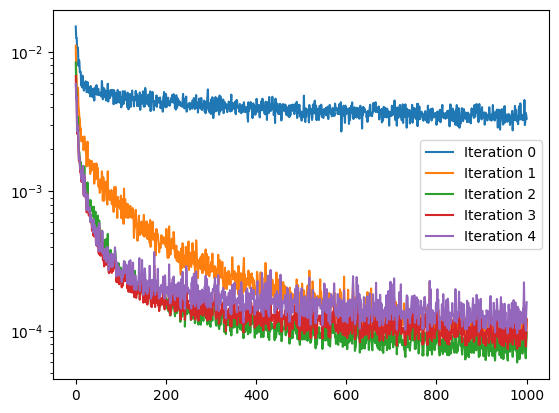

In [12]:
for i in range(max_iterations):
    plt.semilogy(losses[:, i].detach().numpy(), label=f'Iteration {i}')
    plt.legend()    

# Model visualization

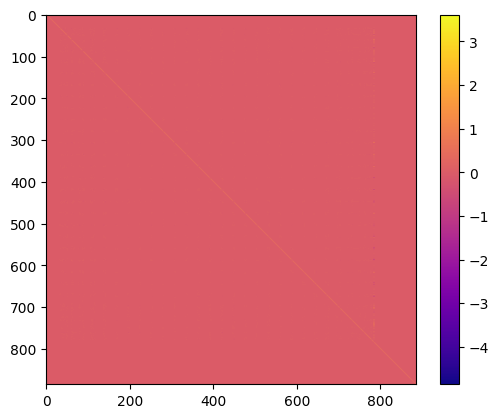

In [13]:
I = torch.eye(z_size).to('cuda')
W1 = map.W1(I).detach().cpu().numpy()
plt.imshow(W1, cmap='plasma')
plt.colorbar()

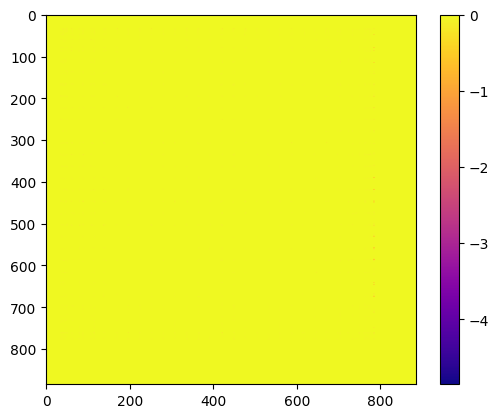

In [14]:
# Plot just the parts of the image where the valye is less than zero
plt.imshow(np.where(W1 < 0, W1, 0), cmap='plasma')
plt.colorbar()

In [15]:
np.where(W1 < -0.5)


(array([ 35,  48,  49,  79,  80,  81,  87, 115, 137, 142, 167, 169, 169,
        194, 197, 224, 252, 253, 279, 282, 307, 310, 334, 362, 390, 391,
        418, 419, 420, 446, 447, 448, 450, 474, 502, 505, 507, 531, 558,
        559, 561, 562, 586, 587, 589, 617, 642, 646, 669, 674, 675, 712,
        713, 750, 761, 764, 765, 777]),
 array([784, 784, 784, 784, 784, 784, 784, 784, 784, 784, 784, 143, 784,
        784, 784, 784, 784, 784, 784, 784, 670, 784, 784, 784, 784, 784,
        784, 784, 784, 784, 784, 784, 784, 784, 784, 784, 784, 784, 784,
        784, 784, 784, 784, 784, 784, 646, 784, 784, 784, 784, 784, 784,
        784, 784, 784, 784, 784, 784]))

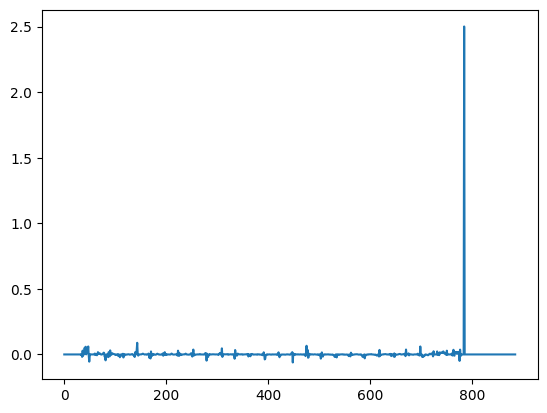

In [16]:
b1 = map.b1.detach().cpu().numpy()
plt.plot(b1)

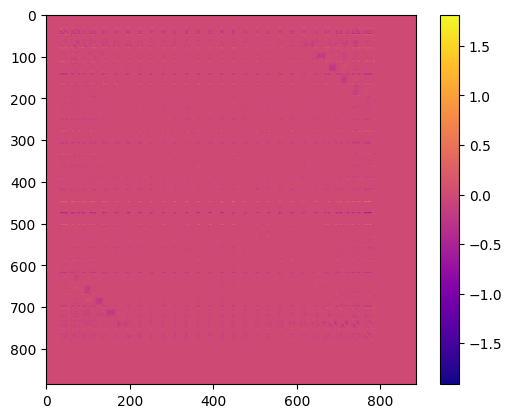

In [17]:
W2 = map.W2(I).detach().cpu().numpy()
plt.imshow(W2, cmap='plasma')
plt.colorbar()

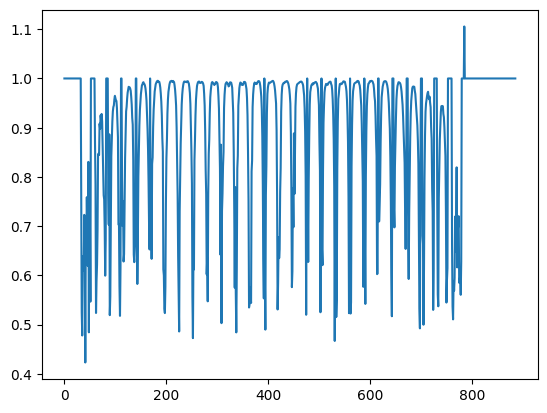

In [18]:
b2 = map.b2.detach().cpu().numpy()
plt.plot(b2)

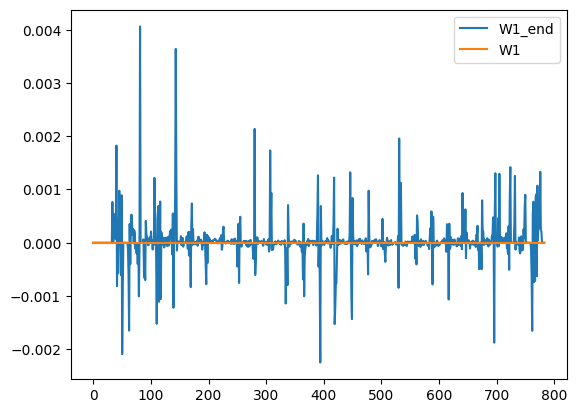

In [19]:
plt.plot(W1[x_size-1, :x_size-1],label='W1_end')
plt.plot(W1[x_size, :x_size-1],label='W1')
plt.legend()


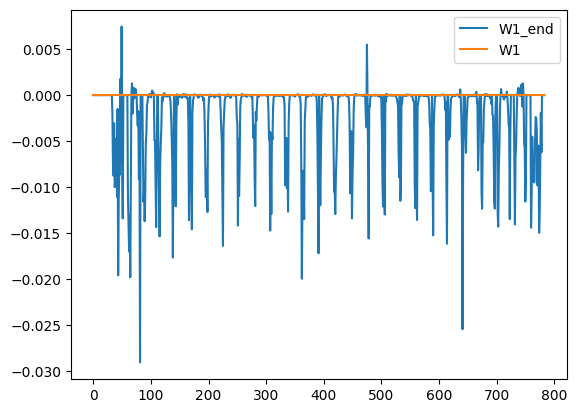

In [20]:
plt.plot(W2[x_size-1, :x_size-1], label='W1_end')
plt.plot(W2[x_size-2, :x_size-2], label='W1')
plt.legend()

# Training data

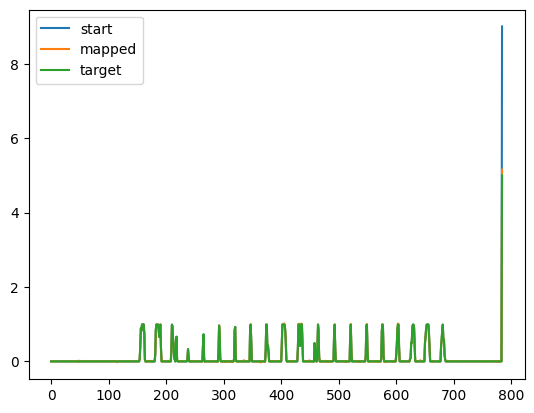

In [21]:
start_batch, target_batch = next(iter(train_loader))
start_batch = start_batch.to('cuda')
target_batch = target_batch.to('cuda')

mapped_batch = start_batch
for i in range(max_iterations):
    mapped_batch = map(mapped_batch)

plot_idx = 0

start_batch = start_batch.to('cpu')
mapped_batch = mapped_batch.to('cpu').detach()
target_batch = target_batch.to('cpu')

plt.plot(start_batch[plot_idx, :x_size],label='start')
plt.plot(mapped_batch[plot_idx, :x_size],label='mapped')
plt.plot(target_batch[plot_idx, :x_size],label='target')
plt.legend()


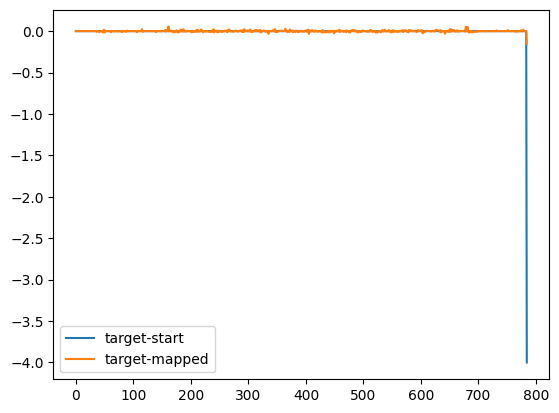

In [22]:
plt.plot(target_batch[plot_idx, :x_size]-start_batch[plot_idx, :x_size], label='target-start')
plt.plot(target_batch[plot_idx, :x_size]-mapped_batch[plot_idx, :x_size], label='target-mapped')
plt.legend()

# Problem specific visualization

tensor(9.)
tensor(5.1537)
tensor(5.)
9.0 5.153727054595947 5.0
7.0 7.518092632293701 8.0
5.0 3.085094451904297 3.0
0.0 7.802727699279785 7.0
1.0 7.95896577835083 8.0
6.0 6.007376670837402 6.0
3.0 0.2127615362405777 0.0
8.0 6.002368450164795 6.0
9.0 3.1565940380096436 3.0
1.0 0.33428075909614563 0.0
2.0 2.980069637298584 3.0
5.0 2.224095582962036 2.0
1.0 9.309961318969727 9.0
6.0 7.236194610595703 7.0
0.0 0.40622296929359436 0.0
9.0 7.174032211303711 7.0
6.0 2.891083002090454 3.0
0.0 4.364474773406982 4.0
6.0 1.1967476606369019 1.0
6.0 1.778747797012329 2.0
6.0 0.04434432461857796 0.0
1.0 8.36193561553955 8.0
2.0 2.9972074031829834 3.0
2.0 4.121105194091797 4.0
8.0 7.2918219566345215 7.0
2.0 2.1394803524017334 2.0
9.0 9.453394889831543 9.0
2.0 1.262091040611267 1.0
5.0 7.107399940490723 7.0
7.0 4.073028564453125 4.0
4.0 8.933899879455566 9.0
1.0 1.863267421722412 2.0
5.0 5.209614276885986 5.0
8.0 0.16093619167804718 0.0
4.0 0.37636613845825195 0.0
1.0 0.9043384790420532 1.0
6.0 1.198947

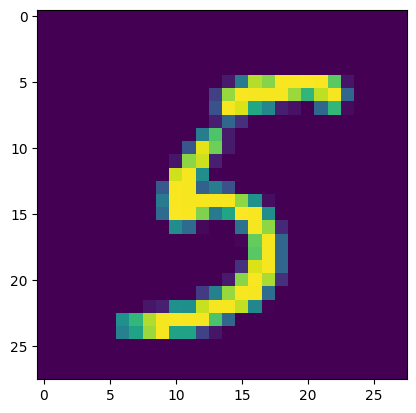

In [23]:
if name == "MNIST":
    plt.imshow(start_batch[plot_idx, :(x_size-1)].reshape(28, 28))
    plt.imshow(mapped_batch[plot_idx, :(x_size-1)].reshape(28, 28))
    plt.imshow(target_batch[plot_idx, :(x_size-1)].reshape(28, 28))

    print(start_batch[plot_idx, x_size-1])
    print(mapped_batch[plot_idx, x_size-1])
    print(target_batch[plot_idx, x_size-1])

    for i in range(start_batch.shape[0]):
        print(f'{start_batch[i, x_size-1]} {mapped_batch[i, x_size-1]} {target_batch[i, x_size-1]}')

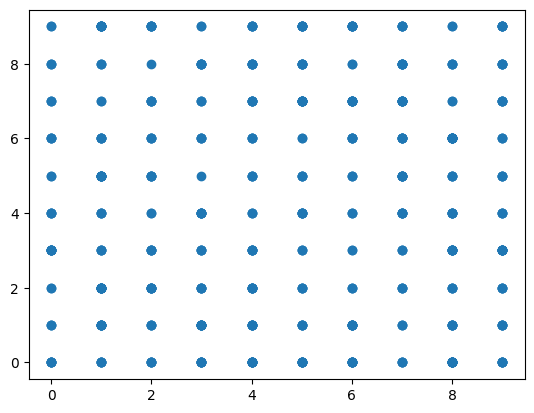

In [24]:
if name == "MNIST":
    y_hat = start_batch[:, x_size-1]
    y = target_batch[:, x_size-1]
    plt.scatter(y_hat, y)

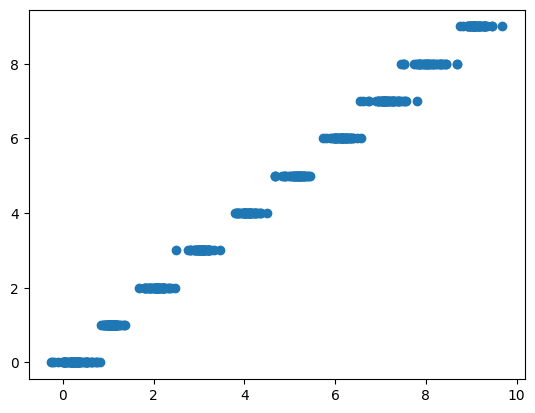

In [25]:
if name == "MNIST":
    y_hat = mapped_batch[:, x_size-1]
    y = target_batch[:, x_size-1]
    plt.scatter(y_hat, y)

In [26]:
if name == 'circle':
    plt.scatter(target_batch[:, 0], target_batch[:, 1], label='target')
    plt.scatter(mapped_batch[:, 0], mapped_batch[:, 1], label='mapped')
    plt.scatter(start_batch[:, 0], start_batch[:, 1], label='start')

In [27]:
if name == 'LunarLander':
    plot_idx = 3
    plt.plot(start_batch[plot_idx, 0:101], start_batch[plot_idx, 101:202], 'o-', label='start')
    plt.plot(mapped_batch[plot_idx, 0:101], mapped_batch[plot_idx, 101:202], 'o-', label='mapped')
    plt.plot(target_batch[plot_idx, 0:101], target_batch[plot_idx, 101:202], 'o-', label='target')
    plt.legend()



# Testing

In [44]:
test_start_batch, test_target_batch = next(iter(test_loader))
test_start_batch = test_start_batch.to('cuda')
test_target_batch = test_target_batch.to('cuda')

test_mapped_batch = test_start_batch
for i in range(5):
    test_mapped_batch = map(test_mapped_batch)

test_start_batch = test_start_batch.to('cpu')
test_mapped_batch = test_mapped_batch.to('cpu').detach()
test_target_batch = test_target_batch.to('cpu')

tensor(4.)
tensor(6.6986)
tensor(7.)
4.0 6.698584079742432 7.0
9.0 6.087019443511963 6.0
3.0 3.546490430831909 3.0
0.0 7.103660583496094 8.0
3.0 2.8196685314178467 2.0
9.0 2.8868062496185303 3.0
7.0 1.840151071548462 2.0
3.0 4.790782928466797 4.0
7.0 0.3702675998210907 3.0
3.0 3.1077466011047363 0.0
1.0 6.367384433746338 6.0
6.0 0.4978339970111847 0.0
6.0 0.16874364018440247 0.0
9.0 9.04508113861084 9.0
8.0 4.694672584533691 5.0
6.0 9.122404098510742 9.0
6.0 1.0991052389144897 1.0
8.0 3.165066719055176 3.0
4.0 4.0824103355407715 5.0
3.0 4.898407936096191 9.0
6.0 1.254750370979309 1.0
9.0 1.0057213306427002 1.0
1.0 6.364367961883545 6.0
4.0 7.084438323974609 7.0
4.0 4.175823211669922 4.0
1.0 6.96607780456543 7.0
9.0 4.335818767547607 5.0
9.0 1.1968469619750977 1.0
9.0 9.529515266418457 9.0
0.0 3.5046916007995605 5.0
1.0 1.933881163597107 2.0
2.0 -0.1635638028383255 0.0
3.0 3.8177359104156494 8.0
0.0 6.75015115737915 6.0
5.0 1.2722415924072266 1.0
5.0 -0.21082821488380432 0.0
2.0 2.82151

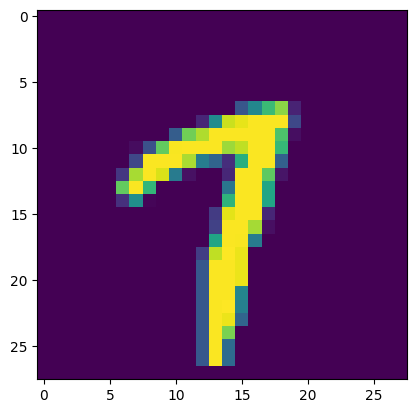

In [45]:
if name == "MNIST":
    plt.imshow(test_start_batch[plot_idx, :(x_size-1)].reshape(28, 28))
    plt.imshow(test_mapped_batch[plot_idx, :(x_size-1)].reshape(28, 28))
    plt.imshow(test_target_batch[plot_idx, :(x_size-1)].reshape(28, 28))

    print(test_start_batch[plot_idx, x_size-1])
    print(test_mapped_batch[plot_idx, x_size-1])
    print(test_target_batch[plot_idx, x_size-1])

    for i in range(test_start_batch.shape[0]):
        print(f'{test_start_batch[i, x_size-1]} {test_mapped_batch[i, x_size-1]} {test_target_batch[i, x_size-1]}')

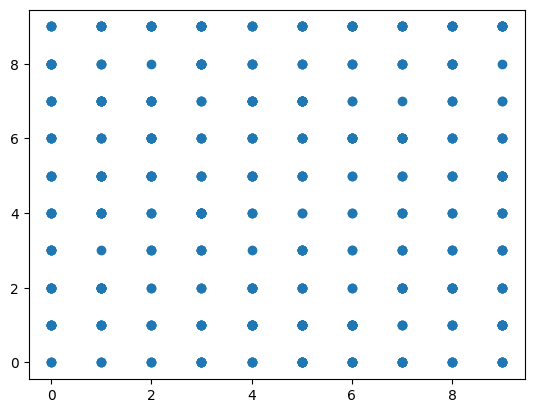

In [46]:
if name == "MNIST":
    y_hat = test_start_batch[:, x_size-1]
    y = test_target_batch[:, x_size-1]
    plt.scatter(y_hat, y)

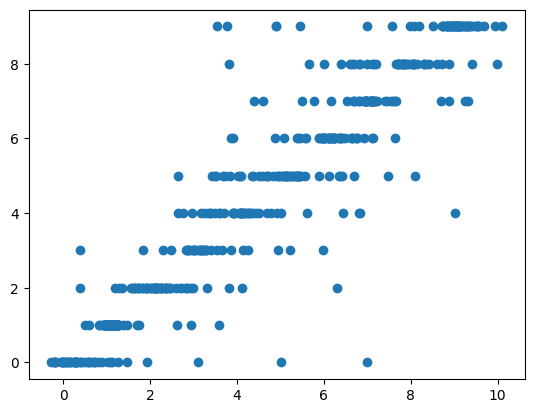

In [47]:
if name == "MNIST":
    y_hat = test_mapped_batch[:, x_size-1]
    y = test_target_batch[:, x_size-1]
    plt.scatter(y_hat, y)